In [1]:
import glob
import japanize_matplotlib
import os
import pandas as pd
import random
import sys
import math
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as sp
from sklearn.metrics import r2_score

In [2]:
def return_fixed_class(BenchMark="bt", Processes=[1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchMarkClass="C"):
        path = './'
        
        # fixed_Class にはベンチマーククラスFixedBenchMarkClassで実行プロセス数がProcessesに該当するものの結果が入る
        fixed_Class = list()

        for process in Processes:
            file_name = ("pprof_"+BenchMark+FixedBenchMarkClass+str(process)+".csv")
            file_path = path+file_name
            if (os.path.exists(file_path) and os.stat(file_path).st_size != 0):
                data_frame = pd.read_csv(path+file_name)
                data_frame = data_frame.set_index(['Name'])
                fixed_Class.append(data_frame.rename(columns = {'#Call': process}).sort_index())
        return(fixed_Class)
    

In [3]:
def return_fixed_process(BenchMark="bt", BenchMarkClasses=["S", "W", "A", "B", "C", "D"], FixedProcess=32):
    path = './'

    # fixed_process には実行プロセス数が64でベンチマーククラスがA ~ Dまでの結果が入る
    fixed_process = list()

    for bench_mark_class in BenchMarkClasses:
        file_name = ("pprof_"+BenchMark+bench_mark_class+str(FixedProcess)+".csv")
        file_path = path+file_name
        if (os.path.exists(file_path) and os.stat(file_path).st_size != 0):
            data_frame = pd.read_csv(path+file_name)
            data_frame = data_frame.set_index(['Name'])
            fixed_process.append(data_frame.rename(columns = {'#Call': bench_mark_class}).sort_index())
    return(fixed_process)
       

# ベンチマーク名：CGを対象にlogでのフィッティングを行う実験

In [4]:
BenchMark_name = "cg"
cg_fixed_class = return_fixed_class(BenchMark=BenchMark_name)
cg_fixed_process = return_fixed_process(BenchMark=BenchMark_name)
summary_fixed_class = pd.concat(cg_fixed_class, axis=1)

columns = summary_fixed_class.columns.to_numpy()

index = summary_fixed_class.index.to_numpy()

dict_summary_fixed_class = {"benchmarks": columns}
for index_name in index:
    dict_summary_fixed_class[index_name] = summary_fixed_class.T[index_name].to_numpy()

In [5]:
class ModelBase:
    def __init__(self, raw_x, raw_y, benchmark_name="benchmark_name", function_name="function_name"):
        self.benchmark_name = benchmark_name
        self.function_name = function_name
        self.xlabel = "実行時のプロセス数"
        self.ylabel = "関数のコール回数"

        test_rate = math.floor(len(raw_x) * 0.3)
        self.raw_x = np.reshape(raw_x, (-1, 1))
        self.raw_y = np.reshape(raw_y, (-1, 1))
        self.train_x = self.raw_x[:-test_rate]
        self.train_y = self.raw_y[:-test_rate]
        self.test_x = self.raw_x[-test_rate:]
        self.test_y = self.raw_y[-test_rate:]
        
        self.x_model_line = np.random.rand(self.raw_x.max(), 1) * self.raw_x.max()
        self.x_model_line.sort(axis=0)
        self.y_model_line = 0
        
        self.lr = 0
        self.r2_score = 0
        
    def calc_lr(self):
        self.lr = 0
     
    def calc_r2_score(self):
        self.r2_score = 0
        
    def plot_graph(self):
        plt.figure()
        plt.plot(self.raw_x, self.raw_y)
        plt.show()
        

In [6]:
class ModelLin(ModelBase):
    def calc_lr(self):
        self.lr = LinearRegression()
        self.lr.fit(self.train_x, self.train_y)
        
    def calc_r2_score(self):
        raw_y_predicted = self.lr.predict(self.raw_x)
        self.r2_score = r2_score(self.raw_y, raw_y_predicted)
        
    def plot_graph(self):
        plt.figure()
        plt.scatter(self.raw_x, self.raw_y)
        self.y_model_line = self.lr.predict(self.x_model_line)
        plt.plot(self.x_model_line, self.y_model_line)
        plt.title(f"ベンチマーク名：{self.benchmark_name}, 関数名：{self.function_name}", y=-0.2)
        plt.xlabel = self.xlabel
        plt.ylabel = self.ylabel
        plt.show()
        

In [7]:
def inverter_log10_func(x):
    return 10**x

class ModelLog10(ModelBase):
    
    def calc_lr(self):
        self.transformer_log10 = sp.FunctionTransformer(func=np.log10, inverse_func=inverter_log10_func)
        x_train_log10 = self.transformer_log10.transform(self.train_x)
        y_train_log10 = self.transformer_log10.transform(self.train_y)
        
        self.lr = LinearRegression()
        self.lr.fit(x_train_log10, y_train_log10)
        
    def calc_r2_score(self):
        raw_x_log10 = self.transformer_log10.transform(self.raw_x)
        raw_y_predicted_log10 = self.lr.predict(raw_x_log10)
        raw_y_predicted = self.transformer_log10.inverse_transform(raw_y_predicted_log10)
        self.r2_score = r2_score(self.raw_y, raw_y_predicted)
        
    def plot_graph(self):
        plt.figure()
        plt.scatter(self.raw_x, self.raw_y)
        x_model_line_log10 = self.transformer_log10.transform(self.x_model_line)
        y_model_line_log10 = self.lr.predict(x_model_line_log10)
        self.y_model_line = self.transformer_log10.inverse_transform(y_model_line_log10)
        plt.plot(self.x_model_line, self.y_model_line)
        plt.title(f"ベンチマーク名：{self.benchmark_name}, 関数名：{self.function_name}", y=-0.2)
        plt.xlabel = self.xlabel
        plt.ylabel = self.ylabel
        plt.show()
        

In [8]:
icnvrt_y = dict_summary_fixed_class["ICNVRT"]
icnvrt_x = dict_summary_fixed_class["benchmarks"]

print(icnvrt_x)
print(icnvrt_y)

[  1   2   4   8  16  32  64 128 256]
[1984770. 2263540. 2821070. 3936140. 3936140. 3936140. 3936140. 3936140.
 3936140.]


-5.0462275697188845
[[24145.17739162]]
[2821071.7816092]


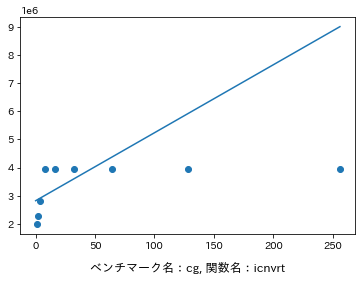

In [9]:
icnvrt_lin = ModelLin(icnvrt_x, icnvrt_y, "cg", "icnvrt")
icnvrt_lin.calc_lr()
icnvrt_lin.calc_r2_score()

print(icnvrt_lin.r2_score)
print(icnvrt_lin.lr.coef_)
print(icnvrt_lin.lr.intercept_)
icnvrt_lin.plot_graph()

-0.2202159804778978
[[0.1800132]]
[6.33503108]


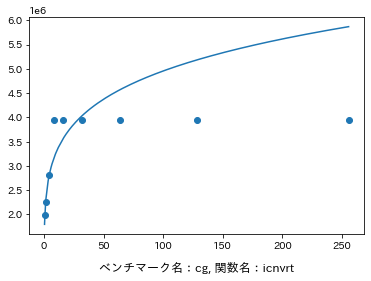

In [10]:
icnvrt_log10 = ModelLog10(icnvrt_x, icnvrt_y, "cg", "icnvrt")

icnvrt_log10.calc_lr()
icnvrt_log10.calc_r2_score()

print(icnvrt_log10.r2_score)
print(icnvrt_log10.lr.coef_)
print(icnvrt_log10.lr.intercept_)
icnvrt_log10.plot_graph()

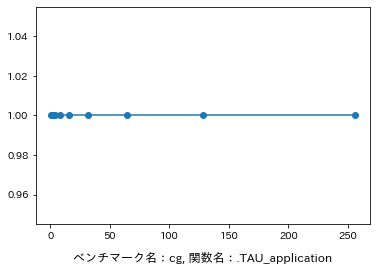

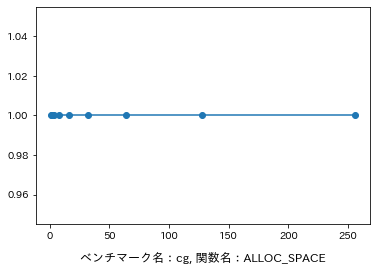

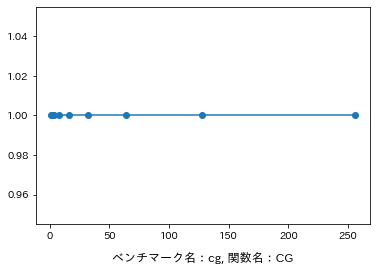

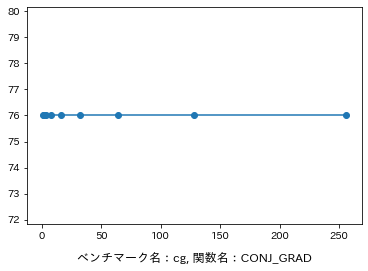

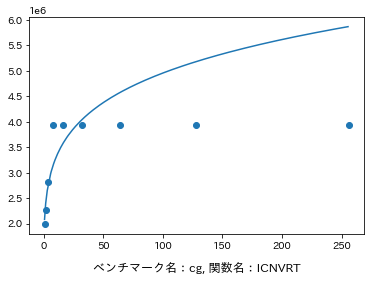

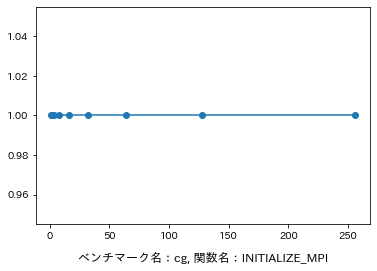

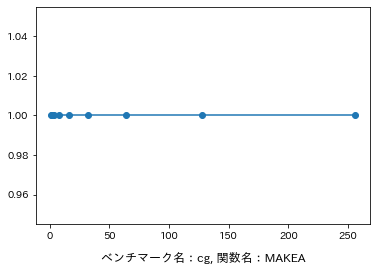

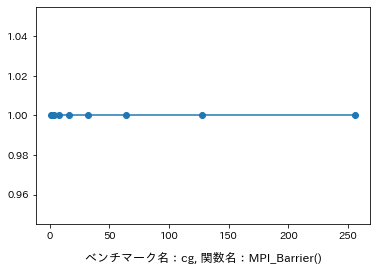

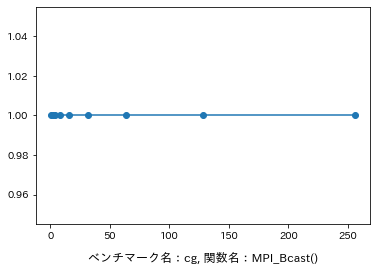

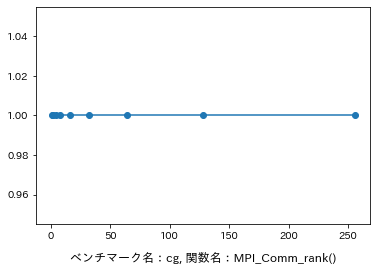

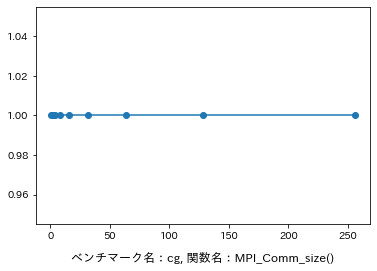

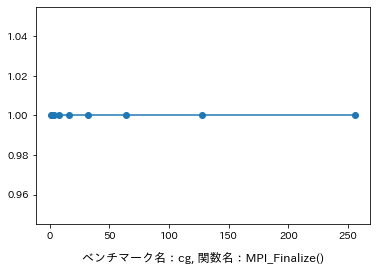

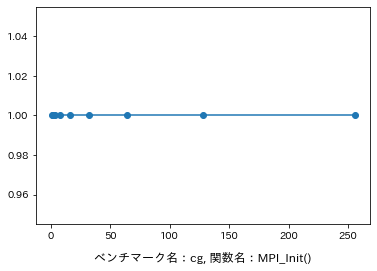

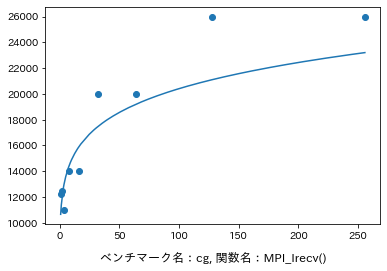

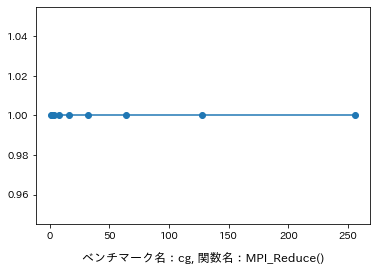

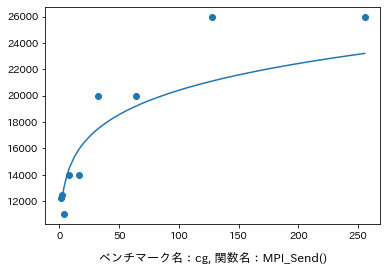

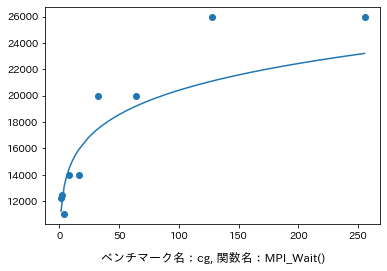

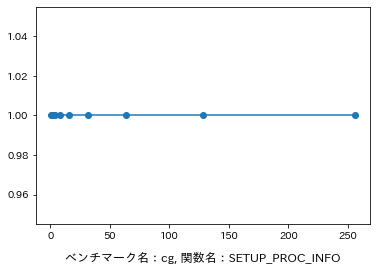

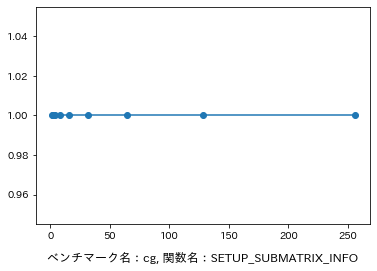

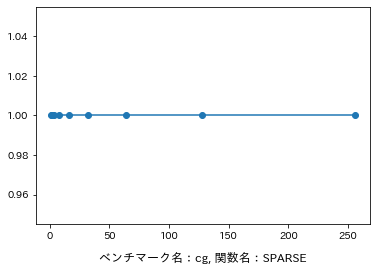

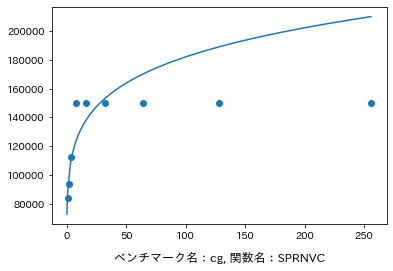

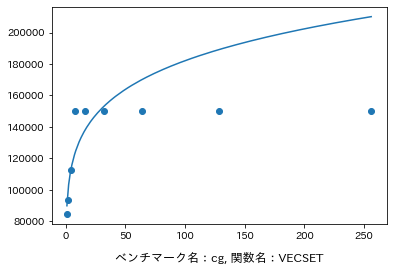

In [11]:
for index_name in index:
    raw_x = dict_summary_fixed_class["benchmarks"]
    raw_y = dict_summary_fixed_class[index_name]
    lin = ModelLin(raw_x, raw_y, "cg", index_name)
    lin.calc_lr()
    lin.calc_r2_score()
    log10 = ModelLog10(raw_x, raw_y, "cg", index_name)
    log10.calc_lr()
    log10.calc_r2_score()
    if(lin.r2_score >= log10.r2_score):
        lin.plot_graph()
    else:
        log10.plot_graph()
    

# ベンチマーク名：LUを対象に反比例モデルでのフィッティングを行う実験

In [12]:
BenchMark_name = "lu"
lu_fixed_class = return_fixed_class(BenchMark=BenchMark_name)
lu_fixed_process = return_fixed_process(BenchMark=BenchMark_name)
summary_fixed_class = pd.concat(lu_fixed_class, axis=1)

columns = summary_fixed_class.columns.to_numpy()

index = summary_fixed_class.index.to_numpy()

dict_summary_fixed_class = {"benchmarks": columns}
for index_name in index:
    dict_summary_fixed_class[index_name] = summary_fixed_class.T[index_name].to_numpy()

[ 2  4  8 16 32 64]
[26781500. 13390700.  6695370.  3347680.  1673840.   836921.]


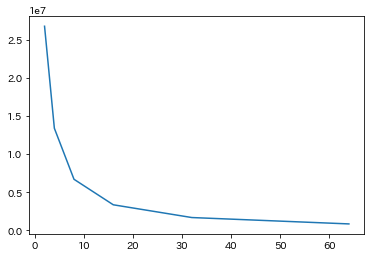

In [13]:
exact_y = dict_summary_fixed_class["EXACT"]
exact_x = dict_summary_fixed_class["benchmarks"]

print(exact_x)
print(exact_y)

plt.figure()
plt.plot(exact_x, exact_y)

In [14]:
# Inverse proportion
def ip_func(x):
    return 1/x

transformer_ip = sp.FunctionTransformer(func=ip_func, inverse_func=ip_func)

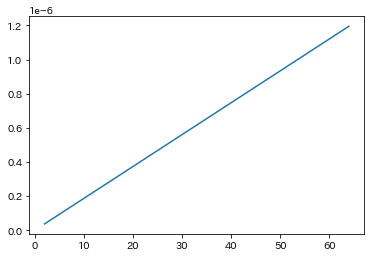

In [15]:
exact_y_ip = transformer_ip.transform(exact_y)

plt.figure()
plt.plot(exact_x, exact_y_ip)

In [16]:
class ModelIP(ModelBase):
    
    def calc_lr(self):
        self.transformer_ip = sp.FunctionTransformer(func=ip_func, inverse_func=ip_func)
        y_train_ip = self.transformer_ip.transform(self.train_y)        
        self.lr = LinearRegression()
        self.lr.fit(self.train_x, y_train_ip)
        
    def calc_r2_score(self):
        raw_y_predicted_ip = self.lr.predict(self.raw_x)
        raw_y_predicted = self.transformer_ip.inverse_transform(raw_y_predicted_ip)
        self.r2_score = r2_score(self.raw_y, raw_y_predicted)
        
    def plot_graph(self):
        plt.figure()
        plt.scatter(self.raw_x, self.raw_y)
        y_model_line_ip = self.lr.predict(self.x_model_line)
        self.y_model_line = self.transformer_ip.inverse_transform(y_model_line_ip)
        plt.plot(self.x_model_line, self.y_model_line)
        plt.title(f"ベンチマーク名：{self.benchmark_name}, 関数名：{self.function_name}", y=-0.2)
        plt.xlabel = self.xlabel
        plt.ylabel = self.ylabel
        plt.show()
        

0.9999999999972695
[[1.86696474e-08]]
[-5.80923749e-14]


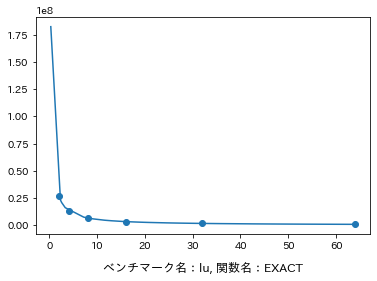

In [17]:
exact_IP = ModelIP(exact_x, exact_y, "lu", "EXACT")

exact_IP.calc_lr()
exact_IP.calc_r2_score()

print(exact_IP.r2_score)
print(exact_IP.lr.coef_)
print(exact_IP.lr.intercept_)
exact_IP.plot_graph()